In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Reading data
The input file is a log produced while running the bulk insertion benchmark for SIFT1M 5 times

In [14]:
# Uncompress the log file if it doesn't exist
if not os.path.exists('memory-accesses.log'):
  !gzip -dk memory-accesses.log.gz

In [15]:
!head -n 10 memory-accesses.log

Filters: [InvertedLists][bulk_insert_entries][test][SIFT1M]
Checking if file cluster/out/SIFT1M/vectors.bin exists
Checking if file cluster/out/SIFT1M/vector_ids.bin exists
Checking if file cluster/out/SIFT1M/list_ids_1024.bin exists
update_entries: 0x7f991225c800 <- 0x7ffcb2cf48c0 (512 bytes)
update_entries: 0x7f991215c800 <- 0x55a31690e580 (8 bytes)
update_entries: took 0.00161349 s
update_entries: 0x7f990fe4e800 <- 0x7ffcb2cf48c0 (512 bytes)
update_entries: 0x7f990fd4e800 <- 0x55a31690e580 (8 bytes)
update_entries: took 0.00167412 s


In [13]:
!cat memory-accesses.log | grep update_entries | wc -l

15000000


In [14]:
!cat memory-accesses.log | grep -vE "Filters|Checking|update_entries|Inserted"

bulk_insert_entries: took 62.2198 s
bulk_insert_entries: took 66.2816 s
bulk_insert_entries: took 66.2513 s
bulk_insert_entries: took 59.47 s
bulk_insert_entries: took 59.8437 s
All tests passed (129001041 assertions in 1 test case)



- No list needs to be copied to a different location in the memory-mapped region, as expected:

In [15]:
!cat memory-accesses.log | grep copy_shared_data | wc -l

0


In [16]:
read_locations = []
write_locations = []
copy_durations = []
bulk_insertion_durations = []
n_runs = 0
with open('memory-accesses.log') as f:
    for line in f:
        if 'cluster/out/SIFT1M/vectors.bin' in line:
            n_runs += 1
            read_locations.append([])
            write_locations.append([])
            copy_durations.append([])
        parts = line.split(' ')
        if 'update_entries: took' in line:
            copy_durations[-1].append(float(parts[2]))
        elif 'update_entries:' in line and '512 bytes' in line:
            read_locations[-1].append(('vec', int(parts[3], 16)))
            write_locations[-1].append(('vec', int(parts[1], 16)))
        elif 'update_entries:' in line and '8 bytes' in line:
            read_locations[-1].append(('idx', int(parts[3], 16)))
            write_locations[-1].append(('idx', int(parts[1], 16)))
        elif 'bulk_insert_entries: took' in line:
            bulk_insertion_durations.append(float(parts[2]))

In [12]:
# Remove the uncompressed file but keep the archive
if os.path.exists('memory-accesses.log.gz'):
  !rm memory-accesses.log

In [17]:
read_locations_vecs = [[l[1] for l in read_locations[run] if l[0] == 'vec'] for run in range(n_runs)]
read_locations_ids = [[l[1] for l in read_locations[run] if l[0] == 'idx'] for run in range(n_runs)]
write_locations_vecs = [[l[1] for l in write_locations[run] if l[0] == 'vec'] for run in range(n_runs)]
write_locations_ids = [[l[1] for l in write_locations[run] if l[0] == 'idx'] for run in range(n_runs)]
print(f'read_locations_vecs: {[hex(l) for l in read_locations_vecs[0][:2]]}')
print(f'write_locations_vecs: {[hex(l) for l in write_locations_vecs[0][:2]]}')
print(f'read_locations_ids: {[hex(l) for l in read_locations_ids[0][:2]]}')
print(f'write_locations_ids: {[hex(l) for l in write_locations_ids[0][:2]]}')

read_locations_vecs: ['0x7ffcb2cf48c0', '0x7ffcb2cf48c0']
write_locations_vecs: ['0x7f991225c800', '0x7f990fe4e800']
read_locations_ids: ['0x55a31690e580', '0x55a31690e580']
write_locations_ids: ['0x7f991215c800', '0x7f990fd4e800']


- As expected, each vector and vector id is copied once for each data point (SIFT1M).
- They are actually copied from seperate buffers in `bulk_insert_entries` into at the end of the list, corresponding to the read `list_id`

In [18]:
print('Number of runs: {}'.format(n_runs))
print('Average number of reads per run: {}'.format(np.mean([len(read_locations_vecs[i]) for i in range(n_runs)])))
print('Average number of writes per run: {}'.format(np.mean([len(write_locations_vecs[i]) for i in range(n_runs)])))

Number of runs: 5
Average number of reads per run: 1000000.0
Average number of writes per run: 1000000.0


In [22]:
total_copy_duration = np.sum(copy_durations, axis=1)
total_copy_duration_mean = np.mean(total_copy_duration)
total_copy_duration_std = np.std(total_copy_duration)
print(f"time spent copying: {round(total_copy_duration_mean, 2)} +- {round(total_copy_duration_std, 2)} s")

time spent copying: 58.66 +- 2.85 s


In [23]:
bulk_insertion_duration_mean = np.mean(bulk_insertion_durations)
bulk_insertion_duration_std = np.std(bulk_insertion_durations)
print(f"time spent bulk inserting: {round(bulk_insertion_duration_mean, 2)} +- {round(bulk_insertion_duration_std, 2)} s")

time spent bulk inserting: 62.81 +- 2.97 s


- $93$% of the time of the `bulk_insert_entries` function is spent in the `memcpy` function, which copies the data from the input buffer to the memory-mapped region.

In [24]:
percentage_spent_copying = total_copy_duration / bulk_insertion_durations
percentage_spent_copying_mean = np.mean(percentage_spent_copying)
percentage_spent_copying_std = np.std(percentage_spent_copying)
print(f"percentage spent copying: {round(percentage_spent_copying_mean, 4) * 100} +- {round(percentage_spent_copying_std, 4) * 100} %")

percentage spent copying: 93.39 +- 0.59 %


# Visualizing memory accesses
## Read locations and write locations
- Since all runs are similar we only look at the first run

/mnt/scratch/tfercho/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


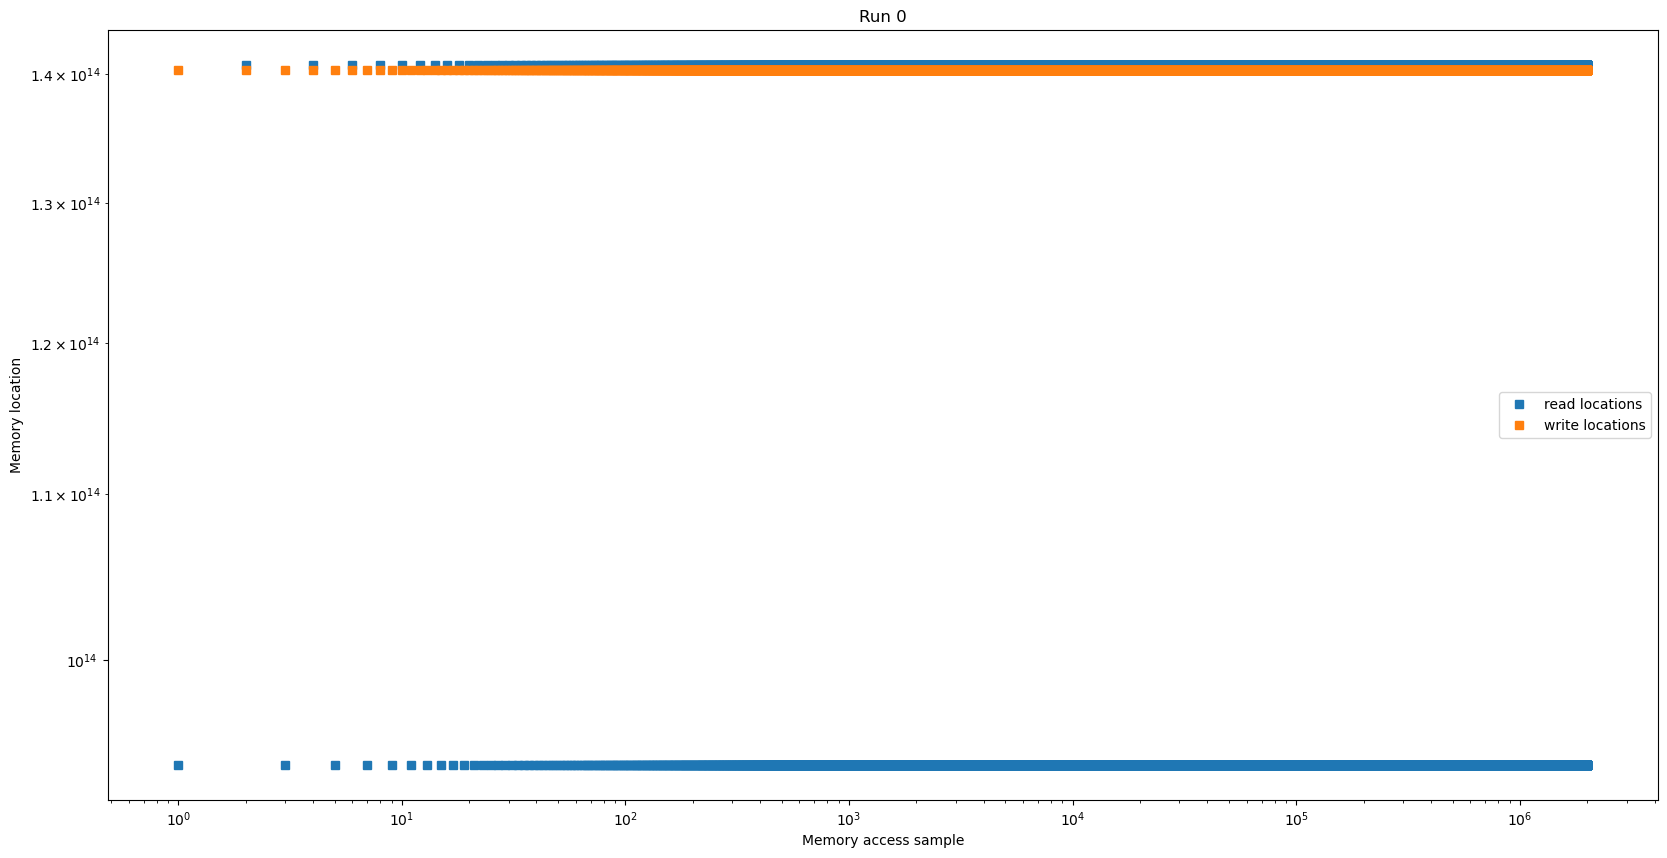

In [27]:
run = 0
read_locations_values = [l[1] for l in read_locations[run]]
write_locations_values = [l[1] for l in write_locations[run]]
plt.figure(figsize=(20, 10))
plt.title('Run {}'.format(run))
plt.plot(read_locations_values, 's', label='read locations')
plt.plot(write_locations_values, 's', label='write locations')
plt.xlabel('Memory access sample')
plt.ylabel('Memory location')
plt.loglog()
plt.legend()
plt.show()


## Unique memory locations

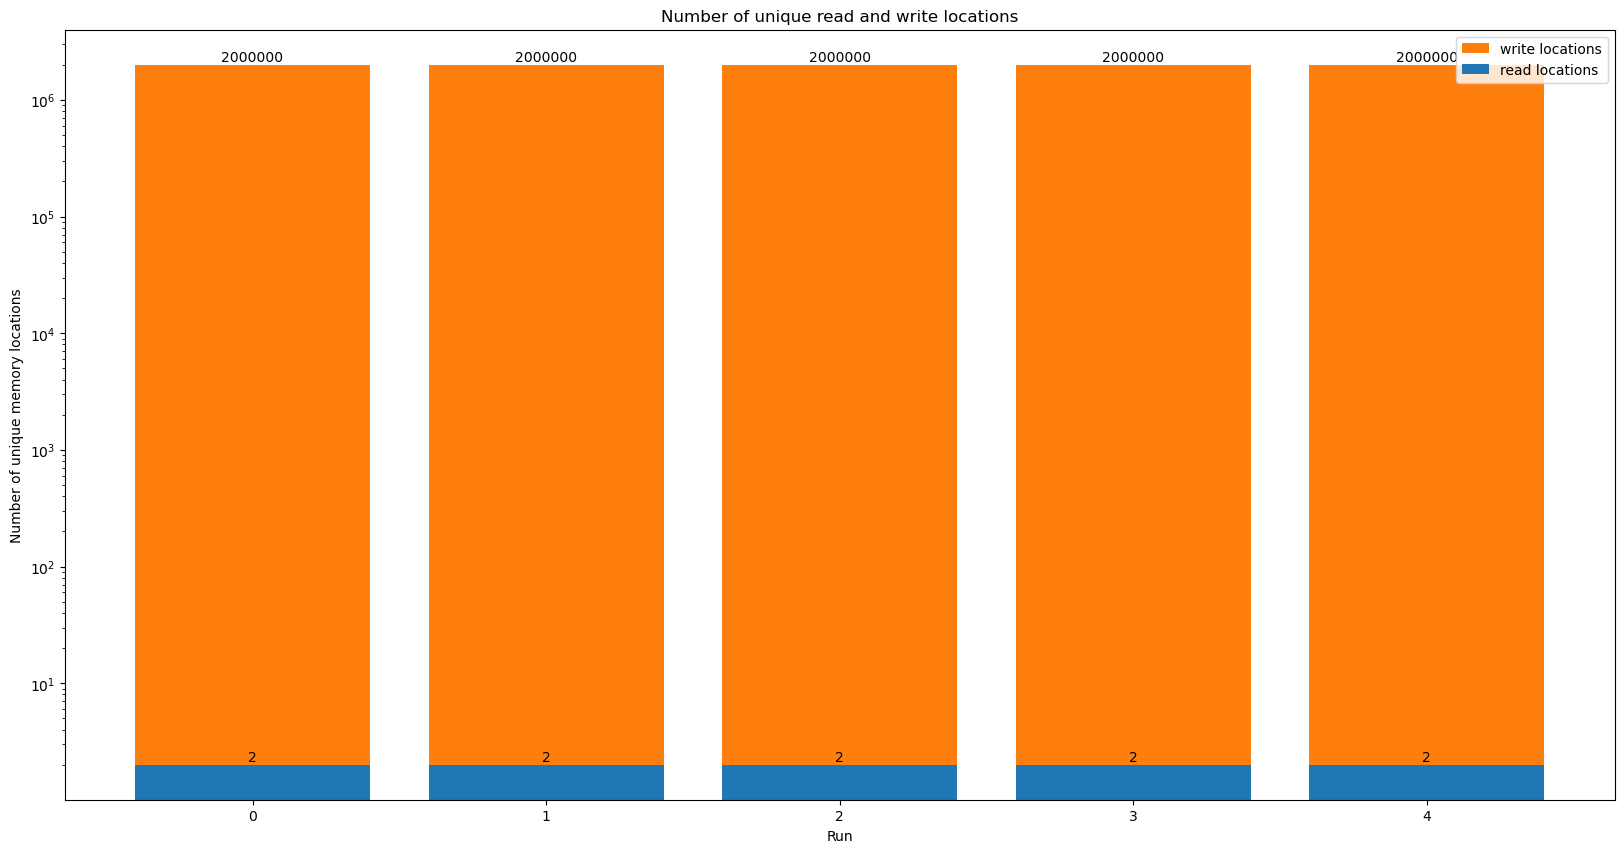

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Number of unique read and write locations')
run_labels = ['{}'.format(run) for run in range(n_runs)]
['{}'.format(run) for run in range(n_runs)]
unique_read_locations = [set(read_locations_vecs[i] + read_locations_ids[i]) for i in range(n_runs)]
n_unique_read_locations = [len(unique_read_locations[i]) for i in range(n_runs)]
unique_write_locations = [set(write_locations_vecs[i] + write_locations_ids[i]) for i in range(n_runs)]
n_unique_write_locations = [len(unique_write_locations[i]) for i in range(n_runs)]

plt.bar(run_labels, n_unique_write_locations, label='write locations', color='#ff7f0e')
plt.bar(run_labels, n_unique_read_locations, label='read locations', color='#1f77b4')
plt.yscale('log')
plt.xlabel('Run')
plt.ylabel('Number of unique memory locations')
for run in range(n_runs):
    plt.text(run, len(set(write_locations_vecs[run] + write_locations_ids[run])), len(set(write_locations_vecs[run] + write_locations_ids[run])), ha='center', va='bottom')
    plt.text(run, len(set(read_locations_vecs[run] + read_locations_ids[run])), len(set(read_locations_vecs[run] + read_locations_ids[run])), ha='center', va='bottom')
plt.legend()
plt.show()


## Unique read locations
- We see that the first memory location `0x7ffcb2cf48c0` is consistenty the same. This is the buffer (allocated on the heap) where the vector is copied from disk.
- The second address varies presumably because it is the memory location on the stack where the vector id is temporarily stored.
### Optimization potential
- There could be some optimization potential here. One could save two memory copy operations per vector by writing the vector and vector id directory to the correct position in the memory mapped file.
- I tried making this change but it did not affect the overall execution time of the bulk insertion. This might be the case since both the input file and the inverted list are on disk and therefore, the data needs to be tempoarily buffered in memory anyway.
- This optimization might show an effect in case we implement an optimized algorithm, which requires the (partial) inverted lists to be in-memory and we would therefore likely see some improvement by saving this copy operation.

In [ ]:
for run in range(n_runs):
    print(f'Run {run}')
    print(f'Number of unique read locations: {n_unique_read_locations[run]}')
    unique_read_locations_to_hex = [hex(location) for location in unique_read_locations[run]]
    print(f'Unique read locations: {unique_read_locations_to_hex}')
    print('')

Run 0
Number of unique read locations: 2
Unique read locations: ['0x7ffcb2cf48c0', '0x55a31690e580']

Run 1
Number of unique read locations: 2
Unique read locations: ['0x7ffcb2cf48c0', '0x55a3169a4470']

Run 2
Number of unique read locations: 2
Unique read locations: ['0x7ffcb2cf48c0', '0x55a3168f9b00']

Run 3
Number of unique read locations: 2
Unique read locations: ['0x7ffcb2cf48c0', '0x55a31698fd80']

Run 4
Number of unique read locations: 2
Unique read locations: ['0x7ffcb2cf48c0', '0x55a3169dfd60']



## Only write locations
- We can see that the write locations on the memory mapped file are (in this logarithmic plot) randomly distributed. This explains the low disk utilization when comparing the performance of the bulk insertion to a sequential copy on disk.
### Optimization potential
- A next step could be to sort the input file by the the list id and see if the write locations are more sequential.
- If this is the case, we found some optimization potential which could be exploited by implementing the bulk insertion e.g. based on the `SPIMI` algorithm
  - Based on the idea of writing to partial lists (in-memory), storing them on disk, and merging them in one pass in the end
  - Avoids random accesses to disk while not requiring to sort the full dataset
  - Runtime $O(n)$ where $n$ is the number of vectors in the collection
  - Sorting is performed on each partial index and is linear in the number of lists $l$: $O(l)$

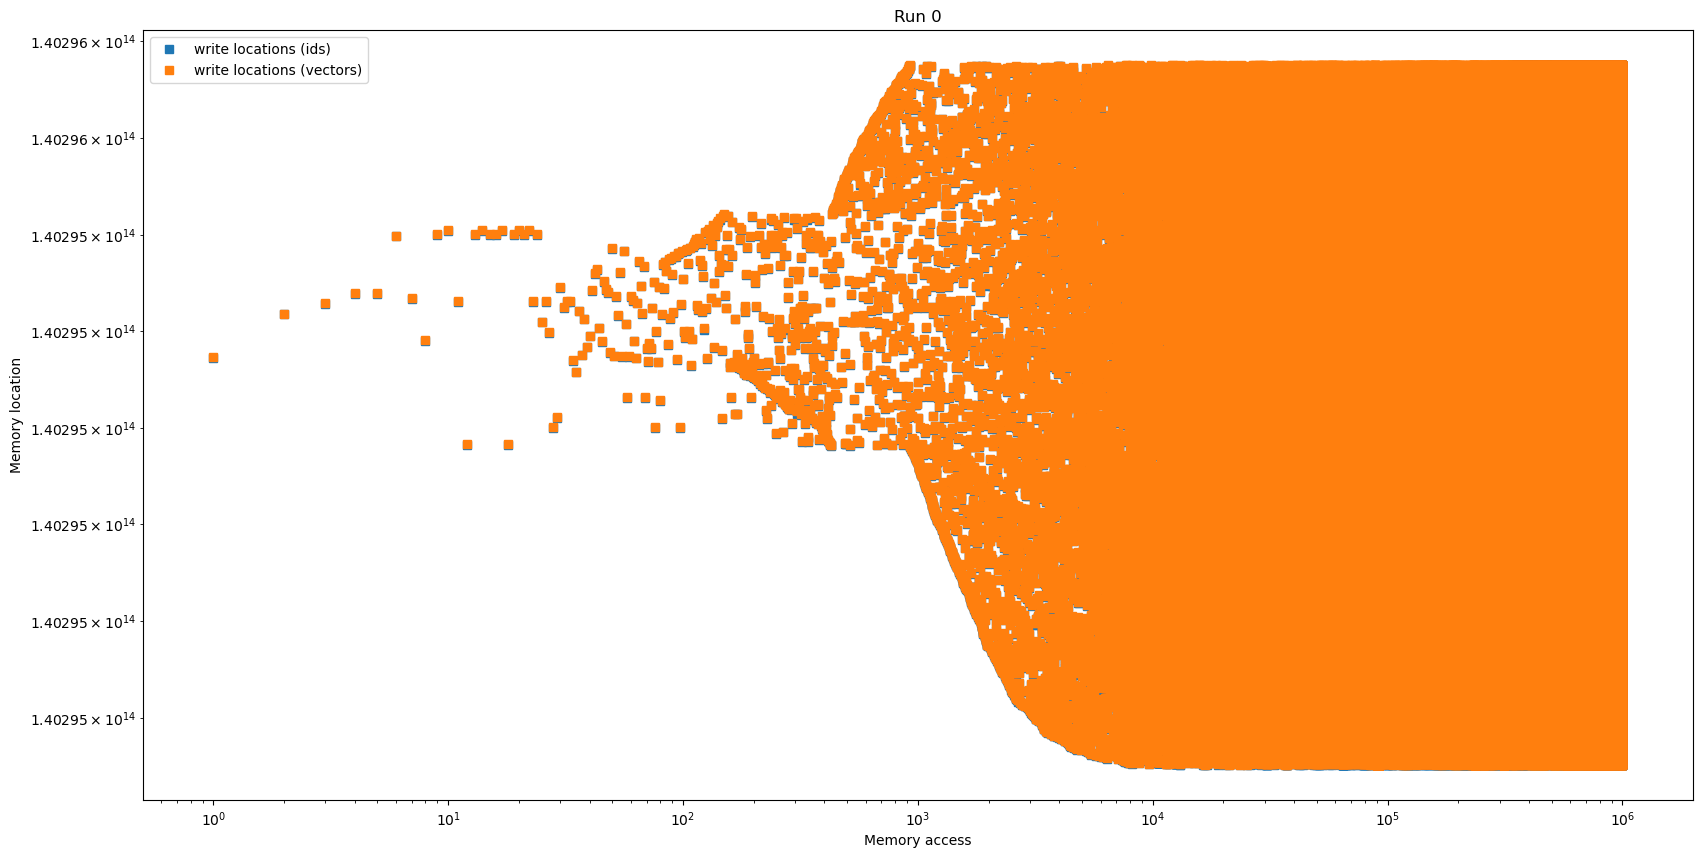

In [29]:
plt.figure(figsize=(20, 10))
plt.title('Run {}'.format(run))
plt.plot(write_locations_ids[run], 's', label='write locations (ids)')
plt.plot(write_locations_vecs[run], 's', label='write locations (vectors)')
plt.xlabel('Memory access')
plt.ylabel('Memory location')
plt.loglog()
plt.legend()
plt.show()